## 1_IRD_CNN_Construction

This jupyter notebook walks through the construction of the IRD CNN training set build, CNN architecture construction, and training. The model architecture code is based off of the code published by Dyer et al., 2021 PNAS and it has been adjusted and updated for this project

In [1]:
# general imports
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from skimage import data,io,filters,draw,util
import os
from skimage.io import imread #smaller part from skimage
%matplotlib inline
from IPython.display import clear_output, display
import pandas as pd
from skimage.morphology import convex_hull_image, erosion, opening,closing, disk
from skimage.filters import rank
from IPython import display
import pylab as pl 
from skimage import exposure

In [2]:
# Tensorflow-specific imports 
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LeakyReLU,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras import regularizers
#from tensorflow.keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
from tensorflow.keras.models import Model # basic class for specifying and training a neural network
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical # utilities for one-hot encoding of ground truth values
## image augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# for the early stopping function 
from tensorflow import keras 
# instead of val split, we manually split so can later check the f1 score 
from sklearn.model_selection import train_test_split

## Training Set Image Preparation 

### X-Ray image enhancement

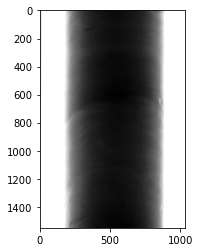

In [4]:
# load in a "model core" image, i.e. an X-ray Image that does not have strong density variations 
im = imread('data/382-U1537D-48F-1-A_820-980_SHLF9956601_20190503000844_k60_a1_t350_n20_RAW.tif')
plt.imshow(im, cmap = 'Greys_r');

In [4]:
# function to make a filter that is based off of the IODP core half-round geometry
def create_filter(im):
    crop = im[0:im.shape[0], 100:1000]
    
    mask = crop
    mask = mask<mask.max()*.9
    mask = opening(mask,disk(5))
    mask = convex_hull_image(mask)
    
    create_mask = mask*1
    new_im = crop*create_mask
    
    ndf = pd.DataFrame(data = new_im)
    ndf = ndf.mean(axis=0)
    filt = np.asarray(ndf)
    return filt

Below, we use the filter function to get the geometry of the IODP core and plot it. This geometry is related to the pixel strength and darkness, and must be substracted from the pixel values to "flatten" the image

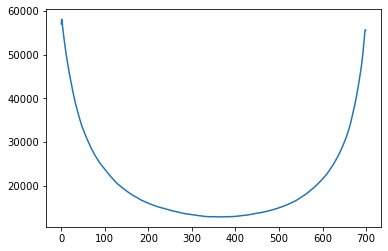

In [5]:
filt = create_filter(im)
start = filt[75]
end = filt[785]
newfilt = filt[80:780]
x = np.arange(len(newfilt))
plt.plot(x,newfilt)

We then use these following functions to prep the raw X-ray images for the contrast enhancement step.

In [6]:
## the raw images have a slight gray region in top left that messes with the masking 

newx = len(newfilt)/2

def picprep(im1):
    whiteout = f.endswith('RAW.tif')
    if whiteout==True:
        im1[0:im1.shape[0], 0:100] = 65535
        return im1
    else:
        return im1

def NEWapplyfilter(im1):
    mask =  im1
    mask = mask<mask.max()*.9
    mask = opening(mask,disk(5))
    mask = convex_hull_image(mask)
    middle_of_core=[]
    for y in range(mask.shape[0]):
        if np.sum(np.where(mask[y,:]))>0:
            middle_of_core.append(np.mean(np.where(mask[y,:])))
    middle_of_core = np.mean(middle_of_core).astype(int)
    xmin = (middle_of_core - newx).astype(np.int64) 
    xmax = (middle_of_core + newx).astype(np.int64)
    left = (im1[0:im1.shape[0], 0:xmin]).astype('float64')
    right = (im1[0:im1.shape[0], xmax:len(im1[0])]).astype('float64')
    filtered = im1[0:im1.shape[0], xmin:xmax] - newfilt
    newim = np.concatenate((left,filtered,right), axis = 1)
    nnewim = newim - newim.min()
    trynew = nnewim / nnewim.max()
    finalim = (trynew * 65535).astype('uint16')
    imeq = exposure.equalize_adapthist(finalim, clip_limit=0.04)
    imeq = (imeq * 65535).astype('uint16')
    return imeq

def NEWcreateimage(im1):
    finim = picprep(im1)
    finim = NEWapplyfilter(finim)
    return finim


## Functions for the training set 

The following functions call the training set folders and preps the images 

In [7]:
def listdir(path):
    return list(listdir_gen(path))

# ignore any .ds_stores 
def listdir_gen(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f         
            
def generate_mask(image, width=100, train=False):
    mask = image
    if width%2!=0:
        width=width-1
        
    mask = mask<mask.max()*.7
    mask = opening(mask,disk(5))
    
    mask = convex_hull_image(mask)
    
    middle_of_core=[]
    for y in range(mask.shape[0]):
        if np.sum(np.where(mask[y,:]))>0:
            middle_of_core.append(np.mean(np.where(mask[y,:])))
    middle_of_core = np.mean(middle_of_core).astype(int)

    if train==False:
        mask2 = np.zeros(mask.shape)
        for y in range(mask.shape[0]):
            if np.sum(mask[y,:])>0:
                left = np.array(middle_of_core-width/2).astype(int)
                right = np.array(middle_of_core+width/2).astype(int)
                mask2[y,left:right]=1
        return mask*mask2
    else:
        return mask
    
def clear_edges(im,side_size): 
    im=np.copy(im) # makes a copy of image, so that one is edited and other stays the same
    im[:int(side_size/2),:]=-1
    im[-1*int(side_size/2):,:]=-1
    im[:,:int(side_size/2)]=-1
    im[:,-1*int(side_size/2):]=-1
    return im

def create_train(filename,train_filename,N,side_size,width=550):
    #im_raw=imread(filename) # old code 
    im_raw_in =imread(filename)
    im_raw = NEWcreateimage(im_raw_in)
    
    if len(im_raw.shape)>2:
        im_raw=rgb2gray(im_raw)
    im_train=imread(train_filename)
    masks=-1*np.ones(im_raw.shape[:2]) #just grabbing shape of image
    core_mask = generate_mask(im_raw,train=True)
    masks[core_mask]=0
    masks[(im_train[:,:,0]>200) & (im_train[:,:,3]>200)]=1
    masks=clear_edges(masks,side_size)
    #makes an image that has -1s outside of the core, 1s where IRD is, and 0 in core that's not IRD

    classes = [0,1] # this is the label on the masks
    names = ['Not IRD','IRD']
    
    tX=np.array([]).reshape(-1,side_size,side_size)
    tY=np.array([])

    for i in classes:
        if np.where(masks==i)[0].size>0:
            X,Y = np.where(masks==i) 
            choices=np.random.choice(np.arange(X.size),N)
            X=X[choices]
            Y=Y[choices]
            training_data_X = np.array([im_raw[int(x-side_size/2):int(x+side_size/2),
                                               int(y-side_size/2):int(y+side_size/2)] for x,y in zip(X,Y)])
                        # gives tX
            training_data_Y = np.array([[i]*training_data_X.shape[0]]).ravel()
            tX=np.append(tX,training_data_X,axis=0)
            tY=np.append(tY,training_data_Y)

    tX=tX.reshape(-1,side_size,side_size,1)
    tY=tY.ravel()
    return tX,tY #training Xs and Ys

def create_train_not_IRD(filename,train_filename,N,side_size,width=550):
    im_raw_in =imread(filename)
    im_raw = NEWcreateimage(im_raw_in)
    
    if len(im_raw.shape)>2:
        im_raw=rgb2gray(im_raw)
    im_train=imread(train_filename)
    masks=-1*np.ones(im_raw.shape[:2]) 
    core_mask = generate_mask(im_raw,train=True)
    masks[core_mask]=0
    masks[(im_train[:,:,0]>200) & (im_train[:,:,3]>200)]=1
    masks=clear_edges(masks,side_size)

    classes = [1] 
    names = ['Not IRD','IRD']
    
    tX=np.array([]).reshape(-1,side_size,side_size)
    tY=np.array([])

    for i in classes:
        if np.where(masks==i)[0].size>0:
            X,Y = np.where(masks==i) 
            choices=np.random.choice(np.arange(X.size),N)
            X=X[choices]
            Y=Y[choices]
            training_data_X = np.array([im_raw[int(x-side_size/2):int(x+side_size/2),
                                               int(y-side_size/2):int(y+side_size/2)] for x,y in zip(X,Y)])
                        # gives tX
            training_data_Y = np.array([[0]*training_data_X.shape[0]]).ravel() 
            tX=np.append(tX,training_data_X,axis=0)
            tY=np.append(tY,training_data_Y)

    tX=tX.reshape(-1,side_size,side_size,1)
    tY=tY.ravel()
    return tX,tY 

def label_image_thresh(im,model,normfactor): 
    memory_buffer = 1000
    im2=clear_edges(np.copy(im),side_size)
    
    # Equalization
    selem = disk(50)
    img_eq = rank.equalize(im2/np.max(im2), selem=selem)
    xv, yv = np.where(img_eq<50)

    print(xv.size)
    xv=np.array(xv).ravel()
    yv=np.array(yv).ravel()
    L2=np.zeros(im.shape)-1
    for i in range(0,xv.size,memory_buffer):
        clear_output()
        if i+memory_buffer<xv.size:
            x_tiny=xv[i:i+memory_buffer]
            y_tiny=yv[i:i+memory_buffer]
        else:
            x_tiny=xv[i:]
            y_tiny=yv[i:]
        to_label_X= np.array([im[int(x-side_size/2):int(x+side_size/2),
                            int(y-side_size/2):int(y+side_size/2)]
                              for x,y in zip(x_tiny,y_tiny)])
        to_label_X=to_label_X.reshape(-1,side_size,side_size,1)
        to_label_X = to_label_X/normfactor 
       
        print('Labeling pixels '+str(i)+' to '
              +str(i+memory_buffer)+' out of '+str(xv.size)+'.\n')
        L=np.argmax(model.predict(to_label_X,verbose=0),axis=1)
   
        i=0
        for x,y in zip(x_tiny,y_tiny):
            L2[x,y]=L[i]
            i+=1
    return L2

In [8]:
# Training Directory
training_dir = 'data/'

#Directory for the raw, original images in the training set 
rawdata_directory=training_dir + 'RAW IMAGES/'
all_rawdata_files=listdir(rawdata_directory) #new listdir removes .ds_store

#Directory for the labeled or "tagged" images 
train_directory=training_dir + 'TAGGED/'
all_train_files=listdir(train_directory)

# nested loop that looks for the relevant filename information from the files
# in all_rawdata_files and places the all_train_files in the correct order
all_train_files_correct_order=[[x for x in all_train_files if f.split('.')[0].split('_SHLF')[0] in x][0] for f in all_rawdata_files]
all_raw_files=[rawdata_directory+r for r in all_rawdata_files]
all_train_files=[train_directory+t for t in all_train_files_correct_order]

N=1000 
side_size= 128 
tX=np.array([]).reshape(-1,side_size,side_size,1)
tY=np.array([])

for f,t in zip(all_raw_files,all_train_files):
    x,y = create_train(f,t,N,side_size)
    tX=np.append(tX,x,axis=0)
    tY=np.append(tY,y)

tX=tX.reshape(-1,side_size,side_size,1)
tY=tY.ravel()

extra_raw_dir = training_dir + "X_RAW IMAGES/"
extra_train_dir = training_dir + "X_TAGGED/" 
extra_raw_files = listdir(extra_raw_dir)
extra_train_files = listdir(extra_train_dir)

extra_raw_files = [extra_raw_dir + r for r in extra_raw_files]
extra_train_files = [extra_train_dir + t for t in extra_train_files]

order=np.argsort([e.split('/')[2] for e in extra_raw_files])
extra_raw_files= np.array(extra_raw_files)[order]
order=np.argsort([e.split('/')[2] for e in extra_train_files])
extra_train_files=np.array(extra_train_files)[order]

for f, t in zip(extra_raw_files, extra_train_files):
    x, y = create_train_not_IRD(f, t, N, side_size)
    tX = np.append(tX, x, axis=0)
    tY = np.append(tY, y)
# tX and tY of all image pairs

tX = tX.reshape(-1, side_size, side_size, 1)
tY = tY.ravel()

print('You have '+str(np.sum(tY).astype(int))+' IRD locations in the training set out of '+str(tY.size)+
     ' ('+np.round(100*(np.sum(tY)/tY.size),2).astype(str)+'%)')

You have 35000 IRD locations in the training set out of 103000 (33.98%)


In [9]:
# 50% of training set IRD and 50% of not IRD
IRDs=np.where(tY==1)[0]
notIRDs=np.where(tY==0)[0]
half_count=np.min([IRDs.size,notIRDs.size])
IRD_choices=np.random.choice(IRDs,half_count,replace=False)
notIRD_choices=np.random.choice(notIRDs,half_count,replace=False)

tY=np.array([tY[IRD_choices],
 tY[notIRD_choices]]).ravel()
tX=np.concatenate([tX[IRD_choices],
 tX[notIRD_choices]])

print('You have '+str(np.sum(tY).astype(int))+' IRD locations in the training set out of '+str(tY.size)+
     ' ('+np.round(100*(np.sum(tY)/tY.size),2).astype(str)+'%)')

You have 35000 IRD locations in the training set out of 70000 (50.0%)


In [10]:
#randomize the order of training tiles
order=np.random.choice(np.arange(0,tY.size),tY.size,replace=False) 
tX=tX[order,:,:,:]
tY=tY[order]

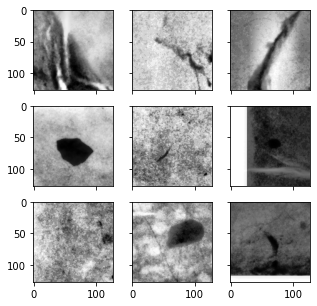

In [15]:
## Data Augmentation ##
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1,0,1]))

datagen = ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip = True,
                             preprocessing_function = orthogonal_rot)

for X_batch, y_batch in datagen.flow(tX, tY, batch_size=9, shuffle=False):
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(5,5))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(side_size,side_size), cmap='Greys_r')
    plt.show()
    break

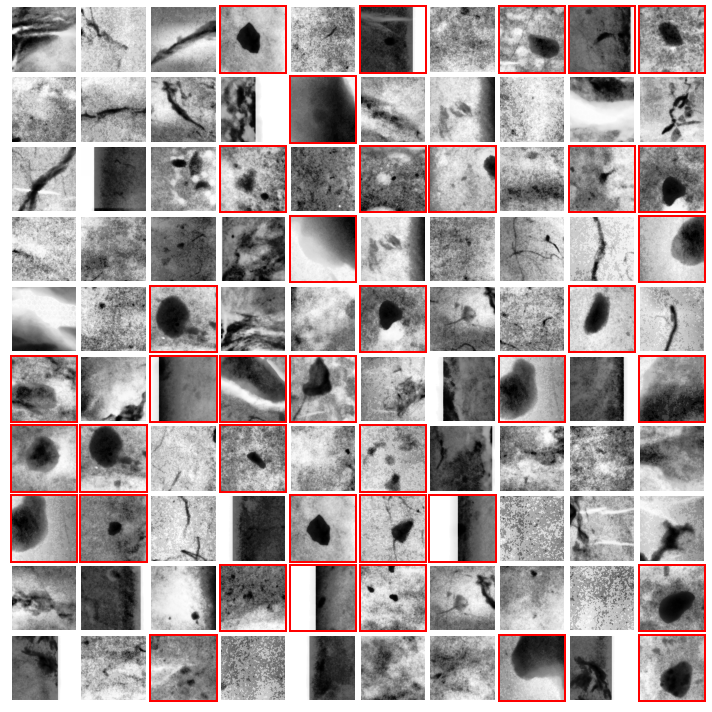

In [12]:
# example of training tiles 
fig=plt.figure(figsize=(10,10))
border_colors = ['white','red'] #red frame = IRD, white = not IRD
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(tX[i][:,:,0],cmap='Greys_r')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    for spine in plt.gca().spines:
        plt.gca().spines[spine].set_color(border_colors[int(tY[i])])
        plt.gca().spines[spine].set_linewidth(2)
fig.tight_layout(w_pad=0,h_pad=0)

In [13]:
num_train, height, width,depth = tX.shape  
num_test = tX.shape[0] 
num_classes = np.unique(tY).shape[0] 
tX = tX.astype('float32') 
maxval=np.percentile(tX.ravel(),95) 
minval=np.percentile(tX.ravel(),5) 
tX = (tX-minval)/(maxval-minval)
tY = to_categorical(tY, num_classes)

In [20]:
batch_size = 32 # in each iteration, we consider 32 training examples at once
kernel_size = 3 # we will use 3x3 kernels throughout, "local neighborhood"
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons

In [21]:
inp = Input(shape=(height, width, depth)) 
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2) #changes resolution 
drop_1 = Dropout(drop_prob_1)(pool_1) 
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2) #drop2 randomly turn off neurons during learning 
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2) 
hidden = Dense(hidden_size, activation='relu')(flat)
drop_3 = Dropout(drop_prob_2)(hidden)
out = Dense(num_classes, activation='softmax')(drop_3)
optimizer=Adam(learning_rate=0.0001) 
model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy']) 

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928 

In [23]:
# random seed for reproducibility
seed = 7
np.random.seed(seed)
X_train, X_test, Y_train, Y_test = (train_test_split(tX, tY, test_size = 0.2, random_state = seed))

In [24]:
acc=np.array([])
val_acc=np.array([])
loss=np.array([])

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15)
log = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
         validation_data=datagen.flow(X_test, Y_test,
         batch_size=32), epochs=200, callbacks = [early_stop],
                verbose=1)

Epoch 1/200
1750/1750 [==============================] - 36s 19ms/step - loss: 0.4884 - accuracy: 0.7605 - val_loss: 0.2444 - val_accuracy: 0.9018
Epoch 2/200
1750/1750 [==============================] - 33s 19ms/step - loss: 0.2434 - accuracy: 0.9018 - val_loss: 0.1833 - val_accuracy: 0.9316
Epoch 3/200
1750/1750 [==============================] - 33s 19ms/step - loss: 0.1968 - accuracy: 0.9220 - val_loss: 0.1578 - val_accuracy: 0.9427
Epoch 4/200
1750/1750 [==============================] - 33s 19ms/step - loss: 0.1649 - accuracy: 0.9365 - val_loss: 0.1496 - val_accuracy: 0.9434
Epoch 5/200
1750/1750 [==============================] - 33s 19ms/step - loss: 0.1488 - accuracy: 0.9443 - val_loss: 0.1300 - val_accuracy: 0.9517
Epoch 6/200
1750/1750 [==============================] - 33s 19ms/step - loss: 0.1333 - accuracy: 0.9505 - val_loss: 0.1163 - val_accuracy: 0.9568
Epoch 7/200
1750/1750 [==============================] - 33s 19ms/step - loss: 0.1154 - accuracy: 0.9567 - val_loss: 0

In [20]:
# save the model with the model run # and number of epochs 
model.save('run_epochnum_epoch_'+
           str(np.round(minval).astype(int))+'-'
           +str(np.round(maxval).astype(int))+'.h5') 
results = pd.DataFrame(log.history)
#results.to_csv('05_48_epoch_results.csv')
results

,loss,accuracy,val_loss,val_accuracy
0,0.611038,0.655000,0.530230,0.761429
1,0.494678,0.766607,0.478670,0.820000
2,0.431659,0.809643,0.382422,0.846429
3,0.369093,0.850179,0.360252,0.856429
4,0.320256,0.870714,0.337063,0.870714
...,...,...,...,...
56,0.074790,0.974286,0.129702,0.950000
57,0.079893,0.970536,0.136935,0.950714
58,0.068892,0.974107,0.135461,0.952857
59,0.076933,0.971429,0.135017,0.952143
